In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt

········


### get data

In [2]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)




#Select those movies which are in the inventory (because only they could be rented) with a JOIN
#also join the rental table with an outer jon because there are movies in the inventory which not have been rented
#include a where condition because we only select movies rented in may 2005
#also get the category id from the category table since this could help the model as well

# onen could include the authors, but it might get a bit tocomplicated so lets try it with the film,inventory,rental data, category

query=''' SELECT f.film_id, i.inventory_id, f.release_year, f.language_id, f.rental_duration, f.rental_rate, f.length, f.rating, fc.category_id, r.rental_id, r.rental_date  
FROM film f
join inventory i
on f.film_id=i.film_id
join film_category fc
on f.film_id=fc.film_id
left join rental r
on i.inventory_id=r.inventory_id AND  MONTH(rental_date)=5 AND YEAR(rental_date)=2005;'''

data = pd.read_sql_query(query, engine)
data.head(20)






,film_id,inventory_id,release_year,language_id,rental_duration,rental_rate,length,rating,category_id,rental_id,rental_date
0,19,93,2006,1,6,0.99,113,PG,1,NaN,NaT
1,19,94,2006,1,6,0.99,113,PG,1,NaN,NaT
2,19,95,2006,1,6,0.99,113,PG,1,588.0,2005-05-28 12:08:37
3,19,96,2006,1,6,0.99,113,PG,1,NaN,NaT
4,19,97,2006,1,6,0.99,113,PG,1,NaN,NaT
5,19,98,2006,1,6,0.99,113,PG,1,NaN,NaT
6,21,102,2006,1,3,4.99,129,R,1,207.0,2005-05-26 08:04:38
7,21,103,2006,1,3,4.99,129,R,1,135.0,2005-05-25 21:58:58
8,21,104,2006,1,3,4.99,129,R,1,NaN,NaT
9,21,105,2006,1,3,4.99,129,R,1,NaN,NaT


### create our category we want to model: boolean if rented in august 2005 or not for each film

In [3]:
# create a boolean if a film was rented last month
#not if a copy was rented but if one or more copeis of a film were rented

def rented(row):
    
    if pd.isnull(row['rental_id']): #if the copy of the film in the invetory wasn rented out may 2005
        return False 
        
    else: #if it was rented out
        return True
        

data['rented_out_mai']= data.apply(rented, axis=1)
data.head(20)

#rented_out_mai is what we want to predict with the model

,film_id,inventory_id,release_year,language_id,rental_duration,rental_rate,length,rating,category_id,rental_id,rental_date,rented_out_mai
0,19,93,2006,1,6,0.99,113,PG,1,NaN,NaT,False
1,19,94,2006,1,6,0.99,113,PG,1,NaN,NaT,False
2,19,95,2006,1,6,0.99,113,PG,1,588.0,2005-05-28 12:08:37,True
3,19,96,2006,1,6,0.99,113,PG,1,NaN,NaT,False
4,19,97,2006,1,6,0.99,113,PG,1,NaN,NaT,False
5,19,98,2006,1,6,0.99,113,PG,1,NaN,NaT,False
6,21,102,2006,1,3,4.99,129,R,1,207.0,2005-05-26 08:04:38,True
7,21,103,2006,1,3,4.99,129,R,1,135.0,2005-05-25 21:58:58,True
8,21,104,2006,1,3,4.99,129,R,1,NaN,NaT,False
9,21,105,2006,1,3,4.99,129,R,1,NaN,NaT,False


In [4]:
#group by film_id, I take max as a function because each value for each film_id is anyway the same
data=data.groupby('film_id').max()
data.head(20)

,inventory_id,release_year,language_id,rental_duration,rental_rate,length,rating,category_id,rental_id,rental_date,rented_out_mai
film_id,,,,,,,,,,,
1,8,2006,1,6,0.99,86,PG,6,972.0,2005-05-30 20:21:07,True
2,11,2006,1,3,4.99,48,G,11,NaN,NaT,False
3,15,2006,1,7,2.99,50,NC-17,6,1033.0,2005-05-31 04:50:07,True
4,22,2006,1,5,2.99,117,G,11,995.0,2005-05-31 00:06:02,True
5,25,2006,1,6,2.99,130,G,8,552.0,2005-05-28 07:53:38,True
6,31,2006,1,3,2.99,169,PG,9,317.0,2005-05-26 23:23:56,True
7,36,2006,1,6,4.99,62,PG-13,5,NaN,NaT,False
8,40,2006,1,6,4.99,54,R,11,1058.0,2005-05-31 08:04:17,True
9,45,2006,1,3,2.99,114,PG-13,11,NaN,NaT,False


## Look at data types and values

In [5]:
data.isna().sum() #check for Nans in data, there are none

inventory_id         0
release_year         0
language_id          0
rental_duration      0
rental_rate          0
length               0
rating               0
category_id          0
rental_id          272
rental_date        272
rented_out_mai       0
dtype: int64

In [6]:
#we can now drop rental_id and rental date because we have that information in our boolean
data=data.drop(['rental_id'], axis=1)
data=data.drop(['rental_date'], axis=1)
data=data.drop(['inventory_id'], axis=1)# also not needed

In [7]:
data.dtypes
# we have only rating as categorical

release_year         int64
language_id          int64
rental_duration      int64
rental_rate        float64
length               int64
rating              object
category_id          int64
rented_out_mai        bool
dtype: object

In [8]:
#language_id, category_id and rental duration we can also see as categorical

data['language_id'].value_counts() #they all have the same language, therefore not useful for categorization
data=data.drop(['language_id'], axis=1)
data.shape

(958, 7)

In [9]:
data['category_id'].value_counts()

15    73
8     67
9     67
2     64
6     63
1     61
7     61
13    60
14    59
3     58
10    58
5     56
4     54
11    53
16    53
12    51
Name: category_id, dtype: int64

In [10]:
data['category_id'] = data['category_id'].astype('object') #category_ids will be treated as object (category)

In [11]:
data['rental_rate'].value_counts()# could also make this category since we just have 3

0.99    326
4.99    320
2.99    312
Name: rental_rate, dtype: int64

In [12]:
data['rental_rate'] = data['rental_rate'].astype('object') 

In [13]:
data['rental_duration'].value_counts()

6    203
3    197
4    194
5    186
7    178
Name: rental_duration, dtype: int64

In [14]:
data['rental_duration'] = data['rental_duration'].astype('object') #rental_duration will be treated as object sicne it doesnt have many values

In [15]:
data.dtypes

release_year        int64
rental_duration    object
rental_rate        object
length              int64
rating             object
category_id        object
rented_out_mai       bool
dtype: object

In [16]:
#check release year
data['release_year'].value_counts()
#they are all from 2006 so we can earse this
#dataset fun fact: we want to predict 2000 June but all movies come out in 2006
data=data.drop(['release_year'], axis=1)

In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
length,958.0,115.490605,40.471844,46.0,80.25,114.0,150.0,185.0


In [18]:
data.head()

,rental_duration,rental_rate,length,rating,category_id,rented_out_mai
film_id,,,,,,
1,6,0.99,86,PG,6,True
2,3,4.99,48,G,11,False
3,7,2.99,50,NC-17,6,True
4,5,2.99,117,G,11,True
5,6,2.99,130,G,8,True


In [19]:
categorical=data.select_dtypes(include=['object'])
categorical.head()

,rental_duration,rental_rate,rating,category_id
film_id,,,,
1,6,0.99,PG,6
2,3,4.99,G,11
3,7,2.99,NC-17,6
4,5,2.99,G,11
5,6,2.99,G,8


In [20]:
# didnt look at rating yet
data['rating'].value_counts() #is nicely equally distribruted like the other catgeory id and rental duration

PG-13    213
NC-17    202
R        189
PG       183
G        171
Name: rating, dtype: int64

In [21]:
# didnt look at rating yet
data['category_id'].value_counts() #is nicely equally distribruted like the other catgeory id and rental duration

15    73
8     67
9     67
2     64
6     63
1     61
7     61
13    60
14    59
3     58
10    58
5     56
4     54
11    53
16    53
12    51
Name: category_id, dtype: int64

### split xy and train-test set split

In [60]:
#split x-y
y = data['rented_out_mai']
X = data.drop('rented_out_mai', axis=1)
#train-test-split typical values for test size is between 20 and 30%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)


#### scale numerical data

In [61]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num =X_train.select_dtypes(include=['float64','int64'])

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)

In [62]:
X_train_norm.shape

(766, 1)

#### one hot encode categorical data

In [63]:
from sklearn.preprocessing import OneHotEncoder


X_train_cat=X_train.select_dtypes(include=['object'])


encoder = OneHotEncoder().fit(X_train_cat)
encoded_for_p = encoder.transform(X_train_cat).toarray()
encoder.categories_
cols = [colname for row in encoder.categories_ for colname in row]
cols
onehot_encoded_for_p = pd.DataFrame(encoded_for_p, columns=cols)
cols_to_drop = [row[0] for row in encoder.categories_]
cols_to_drop
onehot_encoded_for_p = onehot_encoded_for_p.drop(cols_to_drop,axis=1)
onehot_encoded_for_p.head(2)

,4,5,6,7,2.99,4.99,NC-17,PG,PG-13,R,...,7,8,9,10,11,12,13,14,15,16
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#concat categorical & numerical
X_train_transformed = np.concatenate([X_train_norm, onehot_encoded_for_p], axis=1)


In [65]:
X_train_norm.shape

(766, 1)

In [66]:
onehot_encoded_for_p.shape

(766, 24)

### train classifier

In [67]:
from sklearn.linear_model import LogisticRegression #its the classification model
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

### make transformations on x-test data

In [68]:
# for numericals
X_test_num = X_test.select_dtypes(include = np.number)

# Scaling data
# we use the transformer that was trained on the training data
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)

In [69]:
X_test_cat = X_test.select_dtypes(include = np.object)
encoded_for_p2 = encoder.transform(X_test_cat).toarray()
encoded_for_p2
encoder.categories_
cols2 = [colname for row in encoder.categories_ for colname in row]
cols2
onehot_encoded_for_p2 = pd.DataFrame(encoded_for_p2, columns=cols2)
cols_to_drop2 = [row[0] for row in encoder.categories_]
cols_to_drop2
onehot_encoded_for_p2 = onehot_encoded_for_p2.drop(cols_to_drop,axis=1)
onehot_encoded_for_p2.head(2)

<ipython-input-69-4c66609f718a>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_cat = X_test.select_dtypes(include = np.object)


,4,5,6,7,2.99,4.99,NC-17,PG,PG-13,R,...,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
X_test_transformed = np.concatenate([X_test_norm, onehot_encoded_for_p2], axis=1)

### model prediction on test set

In [71]:
predictions = classification.predict(X_test_transformed)
classification.score(X_test_transformed, y_test)

0.7291666666666666

In [72]:
print(y_train.value_counts())

True     545
False    221
Name: rented_out_mai, dtype: int64


In [73]:
print(y_test.value_counts())

True     141
False     51
Name: rented_out_mai, dtype: int64


In [74]:
pd.Series(predictions).value_counts() #therefore model also biased towards true

True     183
False      9
dtype: int64

In [75]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  4,  47],
       [  5, 136]])

[Text(0, 0.5, 'False'), Text(0, 1.5, 'True')]

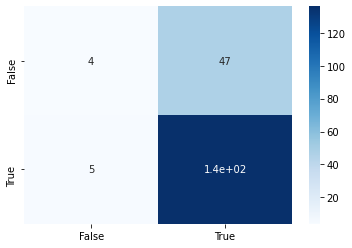

In [76]:
ax= sns.heatmap(confusion_matrix(y_test, predictions), annot=True,cmap='Blues')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

### the model is quit biased towards True and makes a lot of mistakes in identifying a FALSE